In [1]:
import pandas as pd
df = pd.read_csv(r'dstest.csv')
df.head() 

,company,live,mediaEngine,p2p,cdn,upload,peers_count,peers_match,timestamp,sessionDuration,playbackErrorCount,totalPlaybackErrorCount,content
0,Streamroot TV,VOD,ME1,0.0,8507376.0,0.0,0.0,1,1562469807407,120000.0,0,0,content-09235
1,Streamroot TV,VOD,ME1,0.0,5778744.0,0.0,0.0,0,1562469927310,240000.0,0,0,content-09235
2,Streamroot TV,VOD,ME1,0.0,7692960.0,0.0,0.0,0,1562470047330,360000.0,0,0,content-09235
3,Streamroot TV,VOD,ME1,0.0,8229888.0,0.0,0.0,0,1562470167720,480000.0,0,0,content-09235
4,Streamroot TV,VOD,ME1,0.0,10387000.0,0.0,0.0,0,1562470287353,600000.0,0,0,content-09235


Q.1 The goal is to minize the bandwidth and then the volume of data downloaded or uploaded through each connection.
We then could use as a metric the mean of p2p + cdn + upload. This would be the metric to minimize.

Another idea could be the use of maximum instead of the mean but it seems less relevant to me.


In [60]:
df['perfMetric'] = df['p2p'] + df['cdn'] + df['upload']
df.groupby('company').mean()['perfMetric']

company
Flash Infos      3.139543e+07
Sports News      6.562045e+07
Streamroot TV    1.976047e+07
Name: perfMetric, dtype: float64

This metric is difficult to evaluate at first sight.
It is possible to convert it in a percentage performance to make it more readable.

In [61]:
df['perfMeasure'] = 100 *(1-( df['perfMetric']/(df['perfMetric'].max() - df['perfMetric'].min())))
df.groupby('company').mean()['perfMeasure']

company
Flash Infos      94.823962
Sports News      89.181423
Streamroot TV    96.742171
Name: perfMeasure, dtype: float64

Here the Streamroot network seems better optimized than the Sports News network.

Q2 The payload is the first of a session if sessionDurastion is 2 minutes or less.

In [63]:
#Q2.2
df['isFirstPayload'] = df['sessionDuration'] <= 120000

In [64]:
#Q2.3
df.groupby('company').sum()['isFirstPayload']

company
Flash Infos        805.0
Sports News        115.0
Streamroot TV    19914.0
Name: isFirstPayload, dtype: float64

In [65]:
# Q.3.2
df.where(df['playbackErrorCount']!=0).where(df['playbackErrorCount']==df['playbackErrorCount']).count()['totalPlaybackErrorCount']

11

There are 11 distinct viewers that had at least 1 playback error.

In [66]:
# Q4.1
import datetime
# we retrieve the timestamp in seconds and at the beginnig of the payload.
df['readableDate'] = (df['timestamp']//120000 -1)*120
# we convert the timestamp
df['readableDate'] = df['readableDate'].apply(datetime.datetime.fromtimestamp)

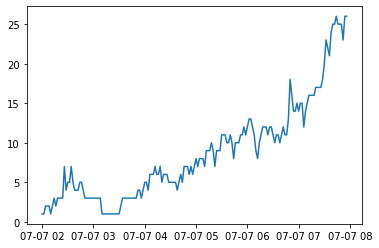

In [67]:
# Q4.2
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

l=df.where(df['content'] == 'content-05335').groupby('readableDate').count()['company']
plt.plot(l)
plt.show()

In [68]:
# Q4.3
# I aggregate the performance metrics and group by content and date.
l =df.groupby(['content', 'readableDate']).agg({'company': 'count', 'perfMetric':'mean', 'perfMeasure':'mean'})
l['concurrency'] = l['company']

# I select the values with a low concurrency
p=l.where(l['concurrency']<10)

# I compute the mean of the metric:
p['weightedPerfMeasure'] = p['concurrency'] * p['perfMeasure']
p['weightedPerfMeasure'].sum()/p['concurrency'].sum()
# Note: I cannot use mean() because the average should be weighted.

96.6853109755023

As we compare to Q1, we can see the that when the concurrency is low, the performance is better.

Q4.4

As I can hardly find a concurrency where I have a performance lower than 80%, I may have made a mistake with my metric.